# Costa Rica Pipeline Notebook
## {Insert info on notebook purpose}

### Project objective:
- {TODO}

#### Notebook sections:
1. Setup
2. English Translations
3. Clean Observational data
4. Extract Medoid and NEM data (provide file of data in case they don't want to run it for hours)
5. Create and Extract Predictor surfaces (pred2)
6. Clean Remote Sensing data
7. Preprocessing
8. Build a predictive model

#### Data sources
- {TODO}

### Section 1: Setup
#### Installing software

In [54]:
pip install pandas numpy geopandas seaborn scikit-learn tensor folium folium matplotlib mapclassify earthengine-api geemap

#### Importing packages

In [55]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import geemap
import ee
import folium

#### Importing our Dataset

In [56]:
# We are importing our csv data, which was collected from John's notebook which gathers the mediod and NEM data from GEE.
df = pd.read_csv('../Data/CostaRica_EE_data.csv')
print(df['geometry'].head())

# Here we change the format of geometry so we can create a geodataframe
df['geometry'] = df['geometry'].apply(
    lambda coord: coord if isinstance(coord, Point) else Point(float(coord.replace('POINT (', '').replace(')', '').split()[0]), 
                                                              float(coord.replace('POINT (', '').replace(')', '').split()[1]))
)
#add notes

0    POINT (-84.90887419133645 10.874761552334505)
1    POINT (-84.90887419133645 10.875185000000002)
2    POINT (-84.90887419133645 10.875608447064252)
3            POINT (-84.908443 10.874761552334505)
4            POINT (-84.908443 10.875185000000002)
Name: geometry, dtype: object


In [57]:
# Convert our csv DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
#gdf.explore(cmap="Blues")
#print(gdf['geometry'].head())
display(gdf)

,Unnamed: 0,plotid,sampleid,Vegetacion,Herbaceas,Pasto_Arb,Cultivo,Humedal,Terreno,Agua,...,lai,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness
0,0,2900,11597,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.335,8132.0,0.806129,69.0,352.00,0.537483,274.05,4.994698,1323.714740,-0.032644
1,1,2900,11598,Herbaceas,Gramineas,Pastos mezclados (70-90%),NaN,NaN,NaN,NaN,...,0.300,8132.0,0.778854,69.0,395.65,0.541566,257.85,1.323483,1323.714740,-0.048439
2,2,2900,11599,Herbaceas,Gramineas,Pastos mezclados (70-90%),NaN,NaN,NaN,NaN,...,0.300,8132.0,0.802353,69.0,395.65,0.413164,257.85,2.645557,1323.714740,-0.009717
3,3,2900,11600,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.335,8132.0,0.837203,69.0,352.00,0.514825,274.05,2.978611,1323.714740,-0.005730
4,4,2900,11601,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300,8132.0,0.834810,69.0,395.65,0.492115,257.85,5.060336,1323.714740,-0.006400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101155,101155,904894,3619577,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.525,8159.0,0.881486,128.0,313.05,0.610894,346.55,23.073408,1324.630000,0.019866
101156,101156,904894,3619578,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.450,8084.0,0.868316,128.0,313.05,0.600563,346.55,13.936700,1324.611453,0.008173
101157,101157,904894,3619579,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.525,8159.0,0.881727,128.0,313.05,0.607081,346.55,37.903484,1324.630000,0.025098
101158,101158,904894,3619580,Arboles,NaN,NaN,NaN,NaN,NaN,NaN,...,0.525,8159.0,0.872697,128.0,313.05,0.594636,346.55,20.788637,1324.630000,0.019301


In [58]:
# Import original observational data into a temporary GeoDataFrame
# This was done because our current GeoDataFrame is missing the 'Uso' and 'Cobertura' columns
tdf = gpd.read_file('../Data/Classification_Plots.zip')

# Save the two columns, from the temporary GeoDataFrame, that we want to insert into our GeoDataFrame (gdf)
uso = tdf['Uso']
cob = tdf['Cobertura']

# Use the Pandas insert function to insert said columns into their original positions
gdf.insert(3, uso.name, uso)
gdf.insert(4, cob.name, cob)

# Remove the trivial column, 'Unnamed: 0', as it was a left-over column which contained data of each row's index
gdf.pop('Unnamed: 0')

# Display our GeoDataFrame to confirm changes
display(gdf)

,plotid,sampleid,Uso,Cobertura,Vegetacion,Herbaceas,Pasto_Arb,Cultivo,Humedal,Terreno,...,lai,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness
0,2900,11597,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.335,8132.0,0.806129,69.0,352.00,0.537483,274.05,4.994698,1323.714740,-0.032644
1,2900,11598,Pastos,Vegetacion,Herbaceas,Gramineas,Pastos mezclados (70-90%),NaN,NaN,NaN,...,0.300,8132.0,0.778854,69.0,395.65,0.541566,257.85,1.323483,1323.714740,-0.048439
2,2900,11599,Pastos,Vegetacion,Herbaceas,Gramineas,Pastos mezclados (70-90%),NaN,NaN,NaN,...,0.300,8132.0,0.802353,69.0,395.65,0.413164,257.85,2.645557,1323.714740,-0.009717
3,2900,11600,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.335,8132.0,0.837203,69.0,352.00,0.514825,274.05,2.978611,1323.714740,-0.005730
4,2900,11601,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.300,8132.0,0.834810,69.0,395.65,0.492115,257.85,5.060336,1323.714740,-0.006400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101155,904894,3619577,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.525,8159.0,0.881486,128.0,313.05,0.610894,346.55,23.073408,1324.630000,0.019866
101156,904894,3619578,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.450,8084.0,0.868316,128.0,313.05,0.600563,346.55,13.936700,1324.611453,0.008173
101157,904894,3619579,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.525,8159.0,0.881727,128.0,313.05,0.607081,346.55,37.903484,1324.630000,0.025098
101158,904894,3619580,Bosque,Vegetacion,Arboles,NaN,NaN,NaN,NaN,NaN,...,0.525,8159.0,0.872697,128.0,313.05,0.594636,346.55,20.788637,1324.630000,0.019301


In [59]:
# Check the number of rows that contain at least one 'NA', or 'NULL', value and print the count (e.g. NaN, NULL, NA)
na_rows=gdf[gdf.isna().any(axis=1)]
print('number of rows with na =',na_rows.shape[0])

# Check the number of rows that contain at least one empty value and print the count (e.g. '')
emp_rows=gdf[(gdf=='').any(axis=1)]
print('number of rows that have empty values =',emp_rows.shape[0])

# Check the number of rows that contain at least one 'zero', value and print the count (e.g. 0)
zero_rows=gdf[(gdf==0).any(axis=1)]
print('number of rows that have zero values =',emp_rows.shape[0])

number of rows with na = 101160
number of rows that have empty values = 0
number of rows that have zero values = 0


# Describing each column Statistically 

In [60]:
print('Summary stats for continuous variables...')

# The describe function (i.e. 'describe()') takes the normal distribution of each column
display(gdf.describe()) 
 
# Notes on the meaning of each row: 
# 'count' is number of instances 
# 'mean' describes the average number 
# 'std' describes how far you deviate from the mean 
# 'min' is the lowest value 
# '25%' is the TODO
# '50%' is the TODO
# '75%' is the TODO
# 'max' is the largest value in column

# Can we make visuals to help decide if we need to remove outliers

Summary stats for continuous variables...


,plotid,sampleid,BLUE,GREEN,NIR,RED,SWIR1,SWIR2,altura2,aspect,...,lai,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness
count,101160.000000,1.011600e+05,101130.000000,101134.000000,101134.000000,101134.000000,101134.000000,101134.000000,97181.000000,101160.000000,...,101160.000000,100982.000000,100792.000000,101160.000000,101160.000000,101134.000000,101160.000000,101160.000000,100982.000000,101134.000000
mean,86794.497420,3.471790e+05,0.028622,0.054576,0.326286,0.040583,0.167247,0.077850,22.636585,171.109960,...,0.424042,8129.081104,0.788556,66.426354,308.684732,0.488191,301.557198,11.868206,1324.070991,-0.014940
std,258528.659228,1.034115e+06,0.055628,0.053711,0.094669,0.055446,0.060418,0.040518,9.236450,105.641588,...,0.198097,37.876898,0.150143,19.969865,64.429899,0.121552,57.613569,10.272339,0.305253,0.048696
min,2.000000,5.000000e+00,-0.188642,-0.069182,-0.008353,-0.080238,-0.000982,0.000777,0.000000,0.000000,...,0.000000,7891.000000,-0.974632,0.000000,0.000000,-0.142855,0.000000,0.000000,1323.644835,-0.277014
25%,2830.750000,1.132300e+04,0.016480,0.037215,0.267527,0.020220,0.129010,0.051542,16.000000,80.692791,...,0.245000,8116.000000,0.748902,55.000000,282.450000,0.425665,281.800000,3.380156,1323.770864,-0.036506
50%,5636.500000,2.254700e+04,0.022998,0.047225,0.325250,0.028910,0.162120,0.068180,22.000000,173.549553,...,0.500000,8128.000000,0.839014,63.000000,309.600000,0.506732,302.850000,8.711405,1324.046264,-0.005657
75%,8445.250000,3.378300e+04,0.030697,0.061738,0.384732,0.047005,0.200757,0.095432,30.000000,264.027390,...,0.615000,8139.000000,0.882352,73.000000,341.350000,0.571769,327.650000,17.920089,1324.330226,0.010607
max,910231.000000,3.640929e+06,1.063955,1.024878,0.980080,1.010193,0.562135,0.481972,51.000000,359.030029,...,0.670000,8390.000000,0.999941,150.000000,778.050000,0.902410,599.550000,72.676102,1324.630000,0.733936


In [61]:
# Displays the data types of each column
print(gdf.dtypes)
print("\n")

#x =gdf.head()
#print(x)

plotid           int64
sampleid         int64
Uso             object
Cobertura       object
Vegetacion      object
Herbaceas       object
Pasto_Arb       object
Cultivo         object
Humedal         object
Terreno         object
Agua            object
Otra_clase      object
SAF             object
Cambios15_      object
Gana_Perdi      object
geometry      geometry
BLUE           float64
GREEN          float64
NIR            float64
RED            float64
SWIR1          float64
SWIR2          float64
altura2        float64
aspect         float64
aspectcos      float64
aspectdeg      float64
aspectsin      float64
brightness     float64
clay_1mMed     float64
diff           float64
elevation      float64
evi            float64
fpar           float64
hand30_100     float64
lai            float64
mTPI           float64
ndvi           float64
ocs_1mMed      float64
sand_1mMed     float64
savi           float64
silt_1mMed     float64
slope          float64
topDiv         float64
wetness    

In [62]:
# Get the boolean Series for null presence and count of nulls in each column
nulls_in_columns = gdf.isna().any()
null_counts = gdf.isna().sum()

# Print the results in a visually aligned format
print(f"{'Column':<20}{'Contains Nulls':<15}\t\t\t{'Null Count':<10}")
print("-" * 55)

for column in gdf.columns:
    has_null = nulls_in_columns[column]
    null_count = null_counts[column]
    print(f"{column:<20}{str(has_null):<15}\t\t\t{null_count:<10}")

Column              Contains Nulls 			Null Count
-------------------------------------------------------
plotid              False          			0         
sampleid            False          			0         
Uso                 True           			216       
Cobertura           True           			216       
Vegetacion          True           			7002      
Herbaceas           True           			76695     
Pasto_Arb           True           			77869     
Cultivo             True           			92762     
Humedal             True           			97234     
Terreno             True           			95602     
Agua                True           			100273    
Otra_clase          True           			95711     
SAF                 True           			92762     
Cambios15_          True           			216       
Gana_Perdi          True           			97928     
geometry            False          			0         
BLUE                True           			30        
GREEN               True           			26        
NIR          

In [63]:
#filling  all the numeric values that are missing with the mean from the column
columns_to_fill = ['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'brightness', 'diff', 'evi', 'hand30_100','mTPI', 'ndvi', 'savi', 'topDiv','wetness']  # Specify the columns to fill
for column in columns_to_fill:
    gdf[column] = gdf[column].fillna(gdf[column].mean())
#Numeric variables are able to be replaced with 

In [64]:
# Displaying all the unique values of the 'Herbaceas' column
unique_values = {'Herbaceas': gdf['Herbaceas'].unique().tolist()}
display(unique_values)

# Translations of unique values:
# Gramineas: Grasses
# Otras Herbaceas: Other Herbaceous (plants)
# Musaceas: Bananas (referring to the family Musaceae, which includes banana plants)

{'Herbaceas': [nan, 'Gramineas', 'Otras Herbaceas', 'Musaceas']}

In [65]:
unique_values = df['Pasto_Arb'].unique()
print(unique_values)
#Pastures typically consist of grasses and legumes, which are cultivated or naturally occurring plants that provide food for grazing animals.
#Management: Pastures can be managed through practices like rotation grazing, where animals are moved between different pasture areas to prevent overgrazing and allow for regrowth.
#Pastos mezclados (70-90%): Mixed Pastures (70-90%)
#Pastos Puros (90-100%): Pure Pastures (90-100%)
#Pastos Combinados (50-70%): Combined Pastures (50-70%)

[nan 'Pastos mezclados (70-90%)' 'Pastos Puros (90-100%)'
 'Pastos Combinados (50-70%)']


In [66]:
unique_values = df['Cultivo'].unique()
print(unique_values)
#Piña: Pineapple
#Otro: Other
#Arroz: Rice
#Cítricos: Citrus (fruits)
#Caña: Sugarcane
#Palma: Palm (often referring to palm trees)
#Banano: Banana
#Melón: Melon
#Sandía: Watermelon
#Café: Coffee


#example. NA not a crop 

[nan 'Pina' 'Otro' 'Arroz' 'Citricos' 'Cana' 'Palma' 'Banano' 'Melon'
 'Sandia' 'Cafe']


In [67]:
unique_values = df['Humedal'].unique()
print(unique_values)
#Pantano (Palustre): Swamp (Marsh)
#Cuerpos de agua: Bodies of water
#Yolillal: (This term refers to a specific type of wetland or habitat, often associated with palm species in tropical areas. It may not have a direct translation.)
#Salinera: Salt flat or Saline area
#Manglar - Mangrove:
#Mangroves are coastal ecosystems found in tropical and subtropical regions, where saltwater from the ocean meets freshwater from rivers. They are directly associated with the ocean and serve as a transition zone between land and sea, providing vital habitats for many marine and terrestrial species.

[nan 'Pantano (Palustre)' 'Cuerpos de agua' 'Yolillal' 'Salinera'
 'Manglar']


In [68]:
unique_values = df['Terreno'].unique()
print(unique_values)
#Otras superficies: Other surfaces
#Terreno descubierto: Exposed land or Bare ground
#Suelo desnudo: Bare soil

[nan 'Otras superficies' 'Terreno descubierto' 'Suelo desnudo']


In [69]:
unique_values = df['Agua'].unique()
print(unique_values)

[nan 'Continentales' 'Mar�timas']


In [70]:
#filtered_gdf = gdf[gdf['Agua'] == 'Continentales']

# Print the first 100 rows (or fewer if less than 100 exist)
#print(filtered_gdf.head(10))

In [71]:
unique_values = df['Otra_clase'].unique()
print(unique_values)
#dificado / Desarrollado: Built-up / Developed (referring to developed or urbanized land)
#Suelo desnudo: Bare soil
#Nubes: Clouds
#Sombra de nubes: Cloud shadow
#Páramo: Páramo (a high-altitude ecosystem in tropical regions, typically above the treeline, found in the Andes mountains, characterized by unique vegetation and climate)
#Playas y arenales: Beaches and sandy areas

[nan 'Edificado / Desarrollado' 'Suelo desnudo' 'Nubes' 'Sombra de nubes'
 'Paramo' 'Playas y arenales']


In [72]:
unique_values = df['SAF'].unique()
print(unique_values)
#Cultivo Puro (90-100%): Pure Crop (90-100%) (indicates fields primarily or exclusively planted with one crop)
#Cultivo mezclado (70-90%): Mixed Crop (70-90%) (fields mostly planted with one crop but mixed with a smaller proportion of other crops)
#Cultivo Combinado (50-70%): Combined Crop (50-70%) (fields with a balanced mix of different crops, but where one may still be dominant)

[nan 'Cultivo Puro (90-100%)' 'Cultivo mezclado (70-90%)'
 'Cultivo Combinado (50-70%)']


In [73]:
unique_values = df['Cambios15_'].unique()
print(unique_values)

['No se determina' 'No' 'Si' nan]


In [74]:
unique_values = df['Gana_Perdi'].unique()
print(unique_values)

[nan 'Perdida de Bosque' 'Ganancia de Bosque']


In [75]:
#lets try and make connections
# Specify the columns you want to analyze
target_column = 'Vegetacion'  # Column you want to examine
condition_column = 'Cultivo'  # Column that should not have NaNs

# Filter rows where 'condition_column' is not NaN
filtered_gdf = gdf[gdf[condition_column].notna()]

# Display the first 10 values in the 'Vegetacion' column for these filtered rows
x= filtered_gdf[target_column].head(10000)

# Display all unique values in the 'Vegetacion' column for these filtered rows
print(x.unique())


['Otra vegetacion' nan 'Herbaceas' 'Arboles' 'Arbustos' 'Palmas' 'Saran'
 'Plastico']


In [76]:
# Example: Filter rows based on a condition in another column
condition_column = 'Herbaceas'  # The column where you have a condition
target_column = 'Pasto_Arb'        # The column you want to examine
condition_value = 'Musaceas'     # The specific value in the condition column
#Gramineas' 'Otras Herbaceas' 'Musaceas'
# Filter rows where `condition_column` equals `condition_value`
filtered_gdf = gdf[gdf[condition_column] == condition_value]

# Display the unique values in `target_column` for these filtered rows
print(filtered_gdf[target_column].unique())


['Pastos Combinados (50-70%)' 'Pastos mezclados (70-90%)' nan
 'Pastos Puros (90-100%)']


In [77]:
gdf2 = gdf.copy()  # Make a copy of the original GeoDataFrame
gdf2['Cultivo'] = gdf2['Cultivo'].replace(np.nan, 'noCrop')  
#Turning all the nan's in cultivo to "Not  crop" because nan just means their not crops

In [78]:
na_count = gdf2['Cultivo'].isna().sum()
print(na_count)
#checking theres no nans
unique_values = gdf2['Cultivo'].unique()
print(unique_values)
#Making a copy for our Crop classifier 
#all nans are gone now 
gdfCrop=gdf2.copy()

0
['noCrop' 'Pina' 'Otro' 'Arroz' 'Citricos' 'Cana' 'Palma' 'Banano' 'Melon'
 'Sandia' 'Cafe']


In [79]:
#LABEL ENCODER 
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#gdf1['Cultivo'] = le.fit_transform(gdf1['Cultivo'])
#gdf1.head()

In [80]:
print(gdf.columns)

Index(['plotid', 'sampleid', 'Uso', 'Cobertura', 'Vegetacion', 'Herbaceas',
       'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase',
       'SAF', 'Cambios15_', 'Gana_Perdi', 'geometry', 'BLUE', 'GREEN', 'NIR',
       'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect', 'aspectcos', 'aspectdeg',
       'aspectsin', 'brightness', 'clay_1mMed', 'diff', 'elevation', 'evi',
       'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed',
       'savi', 'silt_1mMed', 'slope', 'topDiv', 'wetness'],
      dtype='object')


In [81]:
# Step 2: Separate features and target
gdfCrop_sampled = gdfCrop.sample(n=10000, random_state=42)
y = gdfCrop_sampled['Cultivo']
X = gdfCrop_sampled[['BLUE', 'GREEN', 'NIR',
       'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect', 'aspectcos', 'aspectdeg',
       'aspectsin', 'brightness', 'clay_1mMed', 'diff', 'elevation', 'evi',
       'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed',
       'savi', 'silt_1mMed', 'slope', 'topDiv', 'wetness']]

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd


#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the RandomForestClassifier
rndf = RandomForestClassifier(oob_score=True,random_state=0)
rndf.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rndf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print('OOB r-squared =',rndf.oob_score_)
#pd.DataFrame(clf.feature_importances_,index=X,columns=['importance']).sort_values(by='importance').plot(kind='barh', title='Variable Importance')

Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

       Arroz       0.22      0.25      0.24         8
      Banano       0.64      0.60      0.62        15
        Cafe       0.50      0.11      0.18         9
        Cana       0.50      0.12      0.20         8
    Citricos       0.00      0.00      0.00         2
       Melon       0.00      0.00      0.00         8
        Otro       0.00      0.00      0.00        48
       Palma       0.80      0.19      0.31        21
        Pina       1.00      0.35      0.52        20
      Sandia       0.00      0.00      0.00         1
      noCrop       0.95      1.00      0.97      1860

    accuracy                           0.94      2000
   macro avg       0.42      0.24      0.28      2000
weighted avg       0.91      0.94      0.92      2000

OOB r-squared = 0.93


C:\Users\Goldferret\PycharmProjects\NDMN-Jupyter-Notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Goldferret\PycharmProjects\NDMN-Jupyter-Notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Goldferret\PycharmProjects\NDMN-Jupyter-Notebook\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [83]:
# Precision: Precision is the proportion of true positive predictions among all positive predictions for a class. 
#It measures how many selected items are relevant.
#Recall: Recall is the proportion of true positive predictions among all actual instances of that class. 
#It measures how many relevant items are selected.
#Precision: How accurate the model's positive predictions are for that class.
#Recall: How many actual instances of that class were correctly predicted.
#F1-Score: A balance between precision and recall, giving an overall measure of performance.
#Support: The total number of actual samples in each class.

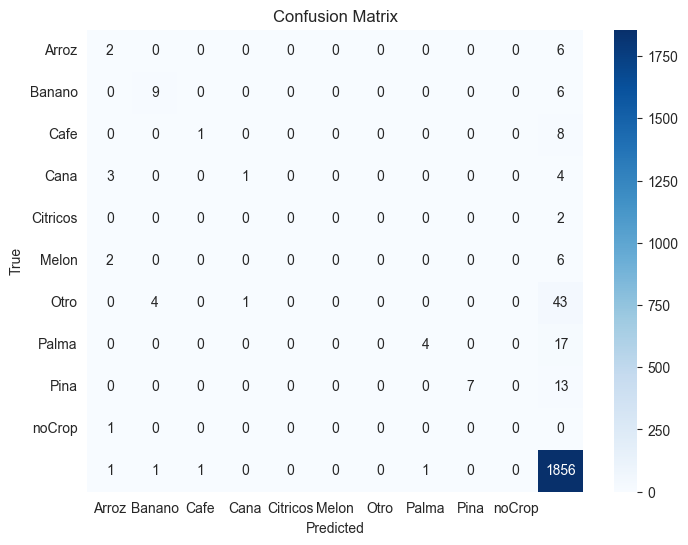

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rndf.classes_, yticklabels=rndf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [85]:
#import pickle

#let's store our models
#pickle.dump(rndf ,open('rndf.mdl','wb'))#random forest regression
#to load our model back into ram we can call the load method for each saved model
#rndf = pickle.load(open('rndf.mdl', 'rb'))

In [86]:
value_percentages = gdfCrop_sampled['Cultivo'].value_counts(normalize=True) * 100
print(value_percentages)

Cultivo
noCrop      91.37
Otro         2.62
Palma        1.47
Pina         1.19
Banano       1.04
Arroz        0.70
Cana         0.55
Cafe         0.53
Melon        0.33
Citricos     0.19
Sandia       0.01
Name: proportion, dtype: float64


In [87]:
# Initialize Earth Engine
ee.Authenticate()  # Authenticate with your Google account if needed
ee.Initialize(project='ee-adamornelas10')


EEException: Caller does not have required permission to use project ee-adamornelas10. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=ee-adamornelas10 and then retry. Propagation of the new permission may take a few minutes.

In [46]:
sample_fc = geemap.geojson_to_ee(gdfCrop_sampled.__geo_interface__)

In [56]:
# Define a classifier and train it on the sample points
classifier = ee.Classifier.smileRandomForest(10)

# Train the classifier using the GeoDataFrame's Feature Collection
trained_classifier = classifier.train(
    features=sample_fc,
    classProperty='Cultivo',  # Adjust to the relevant column in your data
    inputProperties=X.columns.tolist()# Adjust for the feature names
)

#Landsat-8
landsat_image_collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')  # Landsat-8 surface reflectance data

roi =ee.Geometry.Rectangle([-85, 9, -84, 10])



# Filter the image collection for the region of interest (Costa Rica)
image = landsat_image_collection.filterBounds(roi).filterDate('2020-01-01', '2020-12-31').median()  # Adjust the date range as needed

# Apply the classifier to the Landsat-8 image
classified_image = image.select(X.columns.tolist()).classify(trained_classifier)

# Visualize the result
Map.addLayer(classified_image, {'min': 0, 'max': 5, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}, 'classified image')
Map.centerObject(roi, 8)  # Center the map around the region of interest





# Load an example image, classify, and visualize
#image = ee.Image("COPERNICUS/S2")  # Example image collection; adjust as needed
#classified = image.classify(trained_classifier)

# Display the classified map in Jupyter Notebook
#Map = geemap.Map()
#Map.addLayer(classified, {'min': 0, 'max': 5, 'palette': ['blue', 'green', 'yellow']}, "Classified Image")
#Map


EEException: Request payload size exceeds the limit: 10485760 bytes.